In [684]:
%matplotlib inline
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import misc
import numpy as np
import cv2


In [685]:
images = glob.glob(os.path.join('..','data', 'samples', '*'))
images

['..\\data\\samples\\10_left.jpeg',
 '..\\data\\samples\\10_right.jpeg',
 '..\\data\\samples\\13_left.jpeg',
 '..\\data\\samples\\13_right.jpeg',
 '..\\data\\samples\\15_left.jpeg',
 '..\\data\\samples\\15_right.jpeg',
 '..\\data\\samples\\16_left.jpeg',
 '..\\data\\samples\\16_right.jpeg',
 '..\\data\\samples\\17_left.jpeg',
 '..\\data\\samples\\17_right.jpeg']

In [788]:
def smart_crop(im, threshold=30):
    """
    im = image as np array
    threshold = min pixel value for binary-otsu thresholding
    crops eyes out of each image (removes the black background)
    """
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, threshold, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    return im[y:y+h,x:x+w]

In [801]:
def preprocess(im, size=(512, 512), threshold=50):
    im = cv2.imread(im)
    im = crop(im, threshold)
    im = smart_resize(im, size)
    return im

In [802]:
5 % 2. 

1.0

In [803]:
def smart_resize(im, size=(512, 512)):
    """
    resize an image while retaining aspect ratio, pad with black background
    """
    h, w, _ = im.shape
    
    
    if w > h:
        difference = w - h
        top = int((difference/2 + (difference%2)))
        bottom = int(np.ceil(difference/2.))
        left = 0
        right = 0
        im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
    if h > w:
        difference = h - w
        top = 0
        bottom = 0
        left = int((difference/2 + (difference%2)))
        right = int(np.ceil(difference/2.))
        im = cv2.copyMakeBorder(im, top, bottom, left, right,cv2.BORDER_CONSTANT)
    im = cv2.resize(im, size)
    return im

2993 2927
(512L, 512L, 3L)


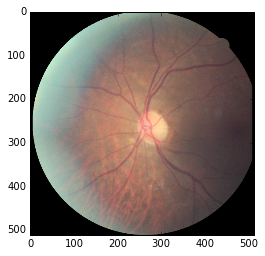

In [804]:
plt.imshow(cv2.cvtColor(preprocess(images[0]), cv2.COLOR_BGR2RGB))

In [805]:
samples = np.array(map(preprocess, images))

2993 2927
(512L, 512L, 3L)
2993 3006
(512L, 512L, 3L)
1941 2026
(512L, 512L, 3L)
1942 2026
(512L, 512L, 3L)
3186 3187
(512L, 512L, 3L)
3186 3187
(512L, 512L, 3L)
2590 3186
(512L, 512L, 3L)
2590 3164
(512L, 512L, 3L)
2460 2468
(512L, 512L, 3L)
2460 2467
(512L, 512L, 3L)


In [806]:
samples.shape

(10L, 512L, 512L, 3L)

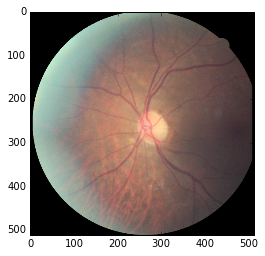

In [807]:
plt.imshow(cv2.cvtColor(samples[0],cv2.COLOR_BGR2RGB))

In [620]:
samples[0].shape[1]

441L